In [1]:
# ENV["CONDA_ENV"]="conda_jl"
# ENV["CONDA_JL_HOME"]="$(ENV["HOME"])/.conda/envs/$(ENV["CONDA_ENV"])"
# ENV["PYTHON"]="$(ENV["CONDA_JL_HOME"])/bin/python"

In [6]:
using DrWatson
@quickactivate "TriangularHubbard"
using TriangularHubbard

using PyCall
using PyPlot
mpl = pyimport("matplotlib")

using LinearAlgebra
using JSON
using DBInterface
using SQLite
using DataFrames
using DataFramesMeta
using LsqFit
using Printf
using Quadmath
using ProgressMeter
using Dates
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

backend_pdf = pyimport("matplotlib.backends.backend_pdf")

PyObject <module 'matplotlib.backends.backend_pdf' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py'>

In [7]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [8]:
shape_str = "(2,-2)x(2,4)"

"(2,-2)x(2,4)"

# 1. Read Lattice Data

In [9]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
reciprocallatticevectors = hcat(jsondata["unitcell"]["reciprocallatticevectors"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)

12×12 Matrix{ComplexF64}:
 1.0+0.0im   1.0+0.0im           1.0+0.0im          …   1.0+0.0im
 1.0+0.0im   0.5-0.866025im     -0.5-0.866025im         0.5+0.866025im
 1.0+0.0im  -0.5-0.866025im     -0.5+0.866025im        -0.5+0.866025im
 1.0+0.0im  -1.0-1.22465e-16im   1.0+2.44929e-16im     -1.0-1.22465e-16im
 1.0+0.0im  -0.5+0.866025im     -0.5-0.866025im        -0.5-0.866025im
 1.0+0.0im   0.5+0.866025im     -0.5+0.866025im     …   0.5-0.866025im
 1.0+0.0im   1.0-2.32525e-16im   1.0-4.65049e-16im     -1.0+7.65714e-16im
 1.0+0.0im   0.5-0.866025im     -0.5-0.866025im        -0.5-0.866025im
 1.0+0.0im  -0.5-0.866025im     -0.5+0.866025im         0.5-0.866025im
 1.0+0.0im  -1.0+7.65714e-16im   1.0-1.53143e-15im      1.0-1.53143e-15im
 1.0+0.0im  -0.5+0.866025im     -0.5-0.866025im     …   0.5+0.866025im
 1.0+0.0im   0.5+0.866025im     -0.5+0.866025im        -0.5+0.866025im

In [10]:
p0 = [4π/3, 0]
R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
zone_boundary = [p0]
p = p0
for i in 1:5
    p = R * p
    push!(zone_boundary, p)
end
push!(zone_boundary, p0)
zone_boundary = hcat(zone_boundary...);

In [11]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, n_sites)
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [12]:
realspacemap_test = ones(Float64, (n_sites, 1))
abs2.(phases * realspacemap_test)

12×1 Matrix{Float64}:
 144.0
   3.463592411986005e-30
   1.2288973789146075e-29
   0.0
   4.7639803104362666e-29
   2.2581143411951463e-29
   1.2561059819587193e-29
   4.44966854351227e-30
   1.858753507927009e-29
   4.6132260218078836e-30
   6.7053176943786e-30
   2.3982604113883167e-28

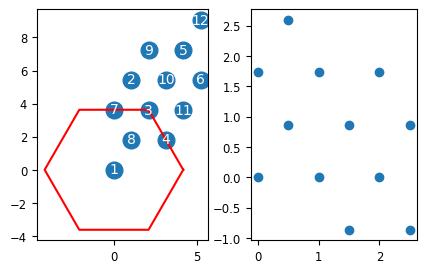

In [14]:
fig = PyPlot.figure(figsize=(5,3))
ax = fig.add_subplot(1,2,1)
ax.plot(2π * momentums[1,:], 2π * momentums[2,:], "o", markersize=12)
for i in 1:size(momentums, 2)
    ax.text(2π * momentums[1,i], 2π * momentums[2,i], "$i", ha="center", va="center", color="w")
end
ax.set_aspect(1.0)
ax.plot(zone_boundary[1,:], zone_boundary[2,:], "r-")


ax = fig.add_subplot(1,2,2)
ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
ax.set_aspect(1.0)

In [23]:
kpoint_index = Dict("Γ" => 1, "K" => 3, "M" => 4, "Λ" => 8);

# 2. Read ED Data

In [49]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
df = DataFrame(DBInterface.execute(conn, """
        SELECT
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          hopping, interaction, temperature,
          base_energy, partition, energy, energy_squared, spin_correlation, 'dense' as type
        FROM dense_results
        JOIN sectors USING(idx)
        JOIN energy_shifts USING(idx, hopping, interaction)
        
        UNION
        
        SELECT
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          hopping, interaction, temperature,
          base_energy, partition, energy, energy_squared, spin_correlation, 'sparse' as type
        FROM sparse_results_collection
        JOIN sectors USING(idx)
        JOIN sparse_energy_shifts USING(idx, hopping, interaction)
        ;
    """))
close(conn)

In [138]:
describe(select(df, Not(:Sq)))

22×7 DataFrame
 Row │ variable        mean          min           median   max        nmissin ⋯
     │ Symbol          Union…        Any           Union…   Any        Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ idx             3380.66       1             3380.5   6721               ⋯
   2 │ nup             6.0           0             6.0      12
   3 │ ndn             6.00032       0             6.0      12
   4 │ tii             5.54537       1             5.0      12
   5 │ pii             2.42884       1             2.0      6                  ⋯
   6 │ pic             1.09869       1             1.0      2
   7 │ dim             2666.52       1             261.0    35556
   8 │ hopping         1.0           1.0           1.0      1.0
   9 │ interaction     20.0          20.0          20.0     20.0               ⋯
  10 │ temperature     4.63716       0.01          4.6      10.0
  11 │ base_energy     34.2426       -13.3236      -1.0     240.0
  12 │ partition       40.1673       0.887079      7.81704  802.462
  13 │ energy          509.331       -1.90136e-15  36.2814  17020.0            ⋯
  14 │ energy_squared  11560.8       0.0           305.467  5.33704e5
  15 │ type                          dense                  sparse
  16 │ charge          12.0003       0             12.0     24
  17 │ Sz              -0.000159185  -6.0          0.0      6.0                ⋯
  18 │ Sz2             6.34432       0.0           4.0      36.0
  19 │ SzSz_Λ          79.435        -3.20577e-15  9.93624  1843.09
  20 │ SzSz_M          80.316        -3.83027e-15  10.1372  1855.63
  21 │ SzSz_Γ          90.0442       -4.86011e-12  31.2362  1389.43            ⋯
  22 │ SzSz_K          80.5653       -4.03844e-15  10.1535  1859.94
                                                               2 columns omitted

In [50]:
hopping = only(unique(df.hopping))
interaction = only(unique(df.interaction))
;

In [51]:
df[!, :charge] = (df[!, :nup] + df[!, :ndn])
df[!, :Sz] = 0.5 .* (df[!, :nup] - df[!, :ndn])
df[!, :Sz2] = df[!, :Sz].^2
;

In [52]:
println(names(df))

["idx", "nup", "ndn", "tii", "pii", "pic", "dim", "hopping", "interaction", "temperature", "base_energy", "partition", "energy", "energy_squared", "spin_correlation", "type", "charge", "Sz", "Sz2"]


In [53]:
rmaps = Vector{Float64}[]
for s in df[!, :spin_correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps, getrealspacemap(m))
end
rmaps = hcat(rmaps...)
kmaps = phases * rmaps

12×684738 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …   6.93889e-17+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -2.67147e-16+3.77482e-32im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -3.36536e-16+1.05926e-31im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -3.19189e-16-8.49769e-33im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -3.36536e-16+2.07615e-31im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  -2.67147e-16+6.16298e-32im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -3.19189e-16+1.65643e-31im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -2.67147e-16-6.50964e-32im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -2.67147e-16-1.54074e-31im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -3.19189e-16+1.32113e-31im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  -2.67147e-16+3.62075e-32im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -2.67147e-16-4.89186e-32im

In [54]:
select!(df, Not(:spin_correlation));

In [55]:
for (name, idx) in kpoint_index
    df[!, "SzSz_$name"] = real.(kmaps[idx,:] .* n_sites);
end

In [56]:
temperatures = unique(sort(df.temperature));
charges = unique(sort(df.charge))
# temperatures = temperatures[ temperatures .>= 0.1];

In [57]:
names(df)

22-element Vector{String}:
 "idx"
 "nup"
 "ndn"
 "tii"
 "pii"
 "pic"
 "dim"
 "hopping"
 "interaction"
 "temperature"
 "base_energy"
 "partition"
 "energy"
 "energy_squared"
 "type"
 "charge"
 "Sz"
 "Sz2"
 "SzSz_Λ"
 "SzSz_M"
 "SzSz_Γ"
 "SzSz_K"

In [58]:
df[!, :Sq] .= eachcol(kmaps);

### Sector-wise weighting

$$
\langle O \rangle
  = \frac{\sum_{i} e^{-E_i / T} O_{ii}}{\sum_{i} e^{-E_i / T}}
  = \frac{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T} O_{ii}}{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T}}
$$

In [59]:
filter(row -> let
    χ1 = row.Sz2 .* row.partition
    χ2 = row.SzSz_Γ
    !isapprox(χ1, χ2; atol=1E-8)
    end, df).idx |> unique

Int64[]

In [60]:
for row in eachrow(df)
    χ1 = row.Sz2 .* row.partition
    χ2 = row.SzSz_Γ
    if !isapprox(χ1, χ2; atol=1E-8)
        println("$(row.idx) $(abs(χ1-χ2))")
    end
end

In [61]:
# Comparing two methods of obtaining susceptibility

out = Dict()
for gdf in groupby(df, [:charge, :temperature]; sort=true)
    min_base_energy = minimum(gdf.base_energy)
    q = first(gdf.charge)
    T = first(gdf.temperature)
    boltzmann = exp.(-(gdf.base_energy .- min_base_energy) ./ T)
    susc1 = sum(gdf.Sz2 .* boltzmann .* gdf.partition) / sum(boltzmann .* gdf.partition) / T
    susc2 = sum(gdf.SzSz_Γ .* boltzmann) / sum(boltzmann .* gdf.partition) / T
    if !haskey(out, q)
        out[q] = []
    end
    push!(out[q], [T, susc1, susc2])
end
for q in keys(out)
    out[q] = hcat(out[q]...)
end

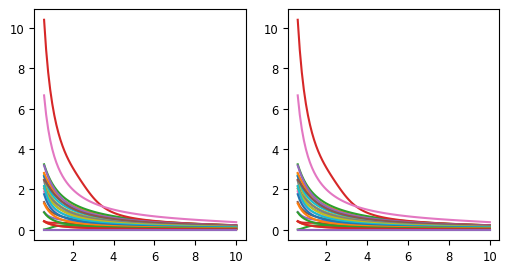

In [62]:
fig = PyPlot.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for charge in sort(collect(keys(out)))
    susceptibility = out[charge]
    ax1.plot(susceptibility[1,15:end], susceptibility[2,15:end], label="$charge")
    ax2.plot(susceptibility[1,15:end], susceptibility[3,15:end], label="$charge")
end
# PyPlot.legend()

In [63]:
# # Check the differences
# for charge in sort(collect(keys(out)))
#     susceptibility = out[charge]
#     @show charge, maximum(abs2.(susceptibility[2, :] - susceptibility[3,:]))
# end

In [64]:
# PyPlot.figure(figsize=(3.5, 3))
# for charge in [5, 6,7,8,9,10,11,12, 13]
#     susceptibility = out[charge]
#     PyPlot.plot(susceptibility[1,5:end], 1 ./ susceptibility[2,5:end], label="$charge")
# end
# PyPlot.legend()
# PyPlot.xlim(0, 5)
# PyPlot.ylim(0, 5)

In [100]:
select_charges = charges[0.5 .< (charges ./ n_sites) .<= 1.5];
select_charge_lookup = Dict(v => k for (k, v) in enumerate(select_charges))
ncols = Int(ceil(sqrt(length(select_charges))))
nrows = Int(ceil(length(select_charges) / ncols))
println(length(select_charges), ", ", nrows, ", ", ncols)

select_temperatures = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
select_temperature_lookup = Dict(v => i for (i, v) in enumerate(select_temperatures))
nrows_T, ncols_T = 3, 3
;

12, 3, 4


# Canonical Ensemble

In [101]:
kpoint_index

Dict{String, Int64} with 4 entries:
  "Λ" => 8
  "M" => 4
  "Γ" => 1
  "K" => 3

In [102]:
canonical_df = let
    Qs = Int[]
    Ts = Float64[]
    χs = Dict{String, Vector{Float64}}(k => Float64[] for (k, _) in kpoint_index)
    χs["0"] = Float64[]
    Cvs = Float64[]
    for sdf in groupby(df, [:charge, :temperature])
        Q = first(sdf.charge)
        T = first(sdf.temperature)
        
        E0 = minimum(sdf.base_energy)
        boltzmann = exp.(-(sdf.base_energy .- E0) ./ T)
        Z = sum(boltzmann .* sdf.partition)
        push!(Qs, Q)
        push!(Ts, T)
        push!(χs["0"], sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
        for kname in keys(kpoint_index)
            push!(χs[kname], sum(sdf[!, "SzSz_$kname"] .* boltzmann) / Z / T)
        end
        let
            corr = sum(
                (sdf.energy_squared
                    + 2 .* sdf.base_energy .* sdf.energy
                    + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
            ) / Z
            avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
            push!(Cvs, (corr - avg^2) / (n_sites * T))
        end
    end
    DataFrame(
        "charge" => Qs,
        "temperature" => Ts,
        "specific_heat" => Cvs,
        "susceptibilities_0" => χs["0"],
        ("susceptibilities_$kname" => χs[kname] for kname in keys(kpoint_index))...,
    )
end

sort!(canonical_df, [:charge, :temperature])
;

# Grand Canonical

In [103]:
grand_canonical_df = let
    chemical_potential_list = -30:0.2:60
    chemical_potentials = Float64[]
    temperatures = Float64[]
    densities = Float64[]

    for sdf in groupby(df, :temperature)
        for μ in chemical_potential_list
            T = first(sdf.temperature)
            E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
            boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)
            push!(chemical_potentials, μ)
            push!(temperatures, T)
            push!(densities, sum(sdf.charge .* boltzmann .* sdf.partition) / sum(boltzmann .* sdf.partition) / n_sites)
        end
    end
    DataFrame(
        "chemical_potential" => chemical_potentials,
        "temperature" => temperatures,
        "density" => densities
    )
end
sort!(grand_canonical_df, [:chemical_potential, :temperature])
;


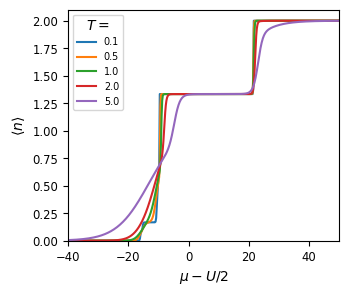

In [104]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
for sdf in groupby(grand_canonical_df, :temperature)
    T = first(sdf.temperature)
    T ∈ [0.1, 0.5, 1.0, 2.0, 5.0] || continue
    ax.plot(sdf.chemical_potential .- interaction / 2, sdf.density, alpha=1, label= (@sprintf "%.1f" T)    )
end
ax.set_xlim(-40, 50)
ax.set_ylim(0, 2.1)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0.5, 1.5)

ax.legend(title="\$T=\$", fontsize="x-small")
ax.set_xlabel(raw"$\mu - U/2$")
ax.set_ylabel(raw"$\langle n \rangle$")
fig.savefig("density-vs-chemical-potential_$shape_str.pdf", dpi=300, bbox_inches="tight")

# Specific Heat

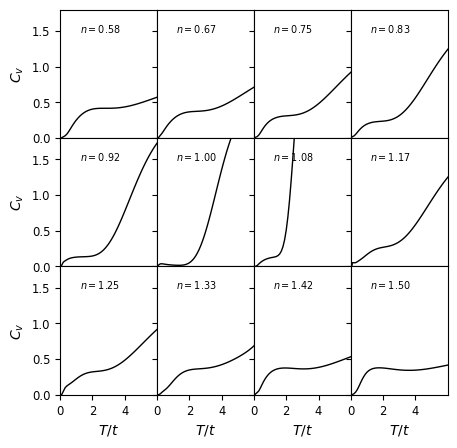

In [105]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )    
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4])
end
axs[1,1].set_xlim(0, 6)
axs[1,1].set_ylim(0, 1.8)

fig.savefig("specific-heat_$(shape_str).pdf", dpi=300, bbox_inches="tight")

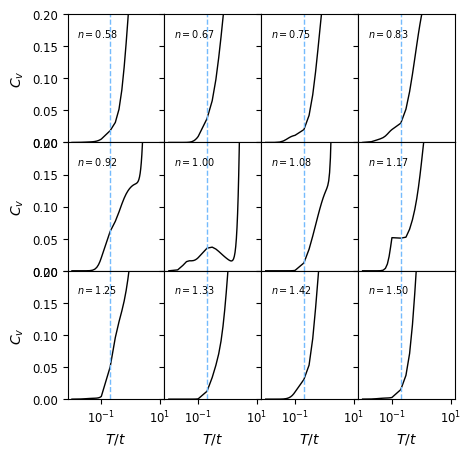

In [106]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
    ax.text(
        0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
    ax.axvline(4*hopping/interaction, linestyle="--", color="xkcd:sky blue", linewidth=1)
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
end
# axs[1,1].set_xlim(0, 0.5)
axs[1,1].set_xscale("log")
axs[1,1].set_ylim(0, 0.2)

fig.savefig("specific-heat-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

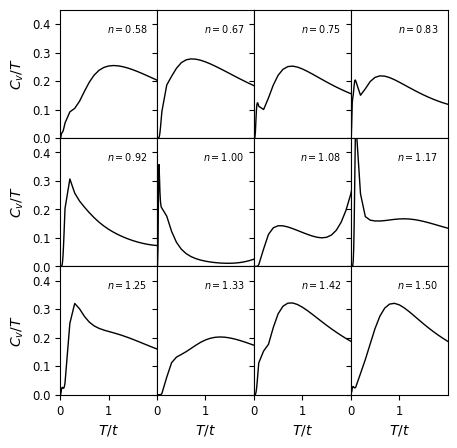

In [107]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.9, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize="x-small"
    )
#     ax.axvline(1/20, linestyle="--")
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,1,])
end
axs[1,1].set_xlim(0, 2)
axs[1,1].set_ylim(0, 0.45)

fig.savefig("entropy_$(shape_str).pdf", dpi=300, bbox_inches="tight")

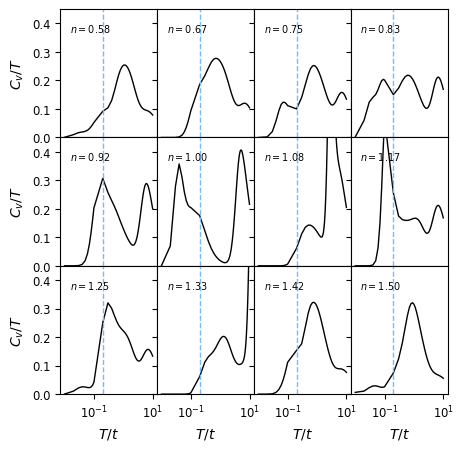

In [108]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
    ax.axvline(4*hopping/interaction, linestyle="--", linewidth=1, color="xkcd:sky blue", )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,1,])
end
# axs[1,1].set_xlim(0, 0.5)
axs[1,1].set_xscale("log")
axs[1,1].set_ylim(0, 0.45)

fig.savefig("entropy-log-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# Linear Fits (Curie-Weiss) (χ(Γ))

In [109]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [114]:
temperature_range = [0.7, 5.5]

fit_df = let
    charges = Int[]
    intercepts = Dict{String, Vector{Float64}}(k => Float64[] for k in keys(kpoint_index))
    intercepts["0"] = []
    slopes = Dict{String, Vector{Float64}}(k => Float64[] for k in keys(kpoint_index))
    slopes["0"] = []
    
    for sdf in groupby(canonical_df, :charge)
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_0) && continue
        any(any(x -> isinf(x) || isnan(x), 1.0 ./ sdf[!, "susceptibilities_$kname"]) for kname in keys(kpoint_index)) && continue
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_0
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(charges, first(sdf.charge))
        push!(intercepts["0"], f.param[2])
        push!(slopes["0"], f.param[1])
                
        for kname in keys(kpoint_index)
            xs = sdf.temperature
            ys = 1 ./ sdf[!, "susceptibilities_$kname"]
            ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
            xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
            f = curve_fit(model, xs, ys, [1.0, 0.0])
            push!(intercepts[kname], f.param[2])
            push!(slopes[kname], f.param[1])
        end
    end
    DataFrame("charge" => charges,
        ("intercept_$kname" => intercepts[kname] for kname in keys(kpoint_index))...,
        ("slope_$kname" => slopes[kname] for kname in keys(kpoint_index))...,
    )
end


23×9 DataFrame
 Row │ charge  intercept_Λ   intercept_M   intercept_Γ    intercept_K   slope_ ⋯
     │ Int64   Float64       Float64       Float64        Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1   1.39787e-16   1.39787e-16    1.39787e-16   1.39787e-16  0.25   ⋯
   2 │      2   0.0574884     0.0463524    -22.0484        0.039103     0.4917
   3 │      3   0.0198851     0.0730058     -1.29408       0.0636376    0.7418
   4 │      4  -0.0090458     0.0895486     -0.75249       0.0805365    0.9923
   5 │      5  -0.029671      0.101199      -0.514031      0.0953727    1.242  ⋯
   6 │      6  -0.0433321     0.110164      -0.379604      0.110959     1.4895
   7 │      7  -0.0502431     0.117806      -0.303389      0.129179     1.7336
   8 │      8  -0.0489996     0.125341      -0.272894      0.151241     1.9717
   9 │      9  -0.0358309     0.132504      -0.272026      0.176478     2.1987 ⋯
  10 │     10  -0.0107584     0.145348      -0.266207      0.205471     2.4085
  11 │     11   0.03341       0.175218      -0.218193      0.24141      2.5877
  ⋮  │   ⋮          ⋮             ⋮              ⋮             ⋮           ⋮   ⋱
  14 │     14   0.0741788     0.0674691     -0.0536897     0.0763703    2.3709
  15 │     15   0.066082      0.0418716     -0.111496      0.0342537    2.1578 ⋯
  16 │     16  -0.032966      0.0564578      7.95818e-5    0.112636     1.7762
  17 │     17   0.0465281     0.0309889     -0.124295     -0.0172881    1.7052
  18 │     18   0.0357937     0.029315      -0.0807949    -0.0346171    1.4709
  19 │     19   0.0260895     0.0249312     -0.0320206    -0.0456231    1.2324 ⋯
  20 │     20   0.0190461     0.0204315     -0.00768454   -0.0488197    0.9900
  21 │     21   0.0131405     0.0148961      0.00338375   -0.0428301    0.7451
  22 │     22   0.00699112    0.00806168     0.0061967    -0.0266215    0.4983
  23 │     23  -5.3858e-16   -1.90245e-16    4.38665e-16  -1.69825e-17  0.25   ⋯
                                                    4 columns and 2 rows omitted

In [115]:
names(canonical_df)

8-element Vector{String}:
 "charge"
 "temperature"
 "specific_heat"
 "susceptibilities_0"
 "susceptibilities_Λ"
 "susceptibilities_M"
 "susceptibilities_Γ"
 "susceptibilities_K"

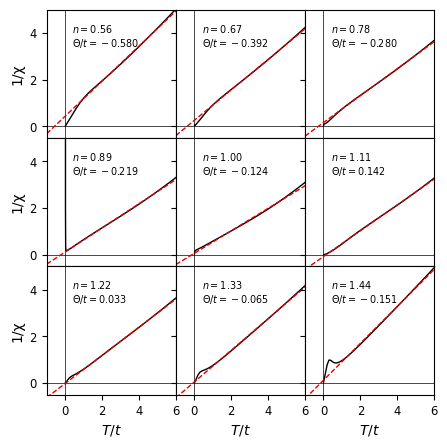

In [34]:
# fig = PyPlot.figure(figsize=(5, 5))
# fig.subplots_adjust(hspace=0, wspace=0)

# ax = nothing
# axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
# axs_transpose = permutedims(axs, [2,1])

# for sdf in groupby(canonical_df, :charge)
#     charge = first(sdf.charge)
#     haskey(select_charge_lookup, charge) || continue
#     iq = select_charge_lookup[charge]
#     ax = axs_transpose[iq]
#     sdf = sort(sdf, order(:temperature))
    
#     xs = sdf.temperature
#     ys = 1.0 ./ sdf.susceptibilities_0
#     # @show ax
#     # @show xs
#     ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
#     ax.axhline(0, linewidth=0.5, color="k")
#     ax.axvline(0, linewidth=0.5, color="k")
# end

# for row in eachrow(fit_df)
#     charge = row.charge
#     haskey(select_charge_lookup, charge) || continue
#     iq = select_charge_lookup[charge]
#     ax = axs_transpose[iq]    
#     xs_fit = [-1, 10]
#     ys_fit = model(xs_fit, [row.slope_0, row.intercept_0])
    
#     ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
#     ax.text(
#         0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_0),
#         transform=ax.transAxes,
#         ha="left", va="top",
#         fontsize="x-small"
#     )
# end

# for i in 1:nrows
#     axs[i, 1].set_ylabel("1/χ")
# end
# for i in 1:ncols
#     axs[end, i].set_xlabel(raw"$T/t$")
#     axs[end, i].set_xticks([0,2,4,6])
# end
# axs[1,1].set_xlim(-1, 6)
# axs[1,1].set_ylim(-0.5, 5)

# fig.savefig("curie-weiss_$(shape_str).pdf", dpi=300, bbox_inches="tight")

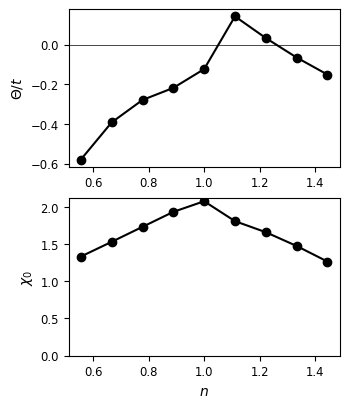

In [35]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_0, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_0, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

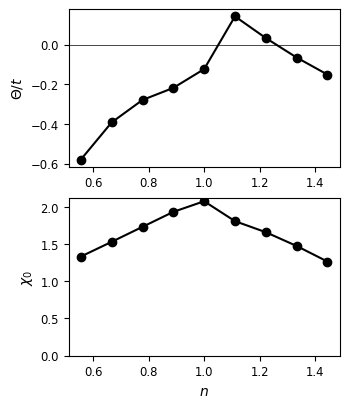

In [36]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Γ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Γ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

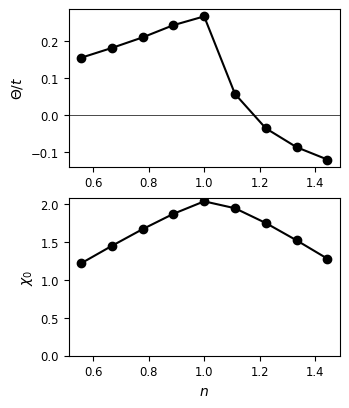

In [37]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_K, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_K, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-K_$(shape_str).pdf", dpi=300, bbox_inches="tight")

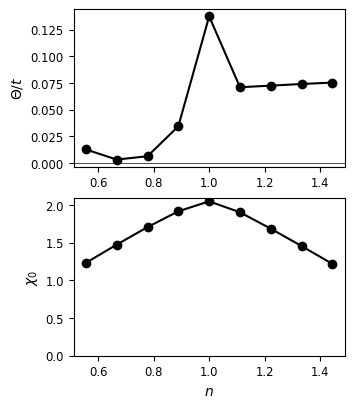

In [38]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Σ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-SM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

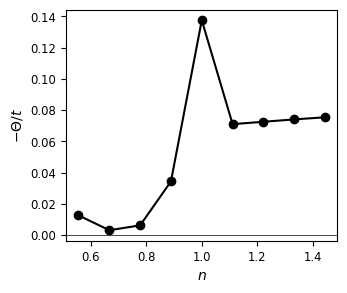

PyObject Text(24.999999999999993, 0.5, '$-\\Theta/t$')

In [39]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()

let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
    ax.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
end
ax.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\Theta/t$")
# fig.savefig("weiss-temperature_$(shape_str).pdf", dpi=300, bbox_inches="tight")

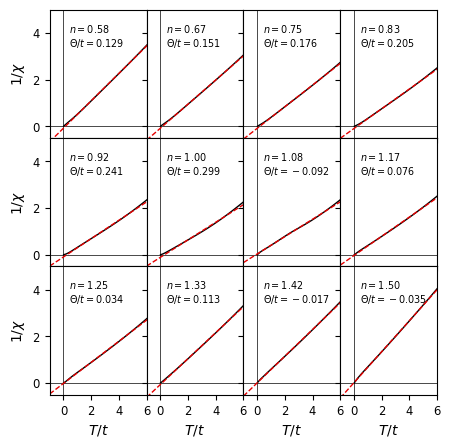

In [118]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for kname in keys(kpoint_index)
    fig.clf()

    ax = nothing
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])

    for sdf in groupby(canonical_df, :charge)
        charge = first(sdf.charge)
        haskey(select_charge_lookup, charge) || continue
        iq = select_charge_lookup[charge]
        ax = axs_transpose[iq]
        sdf = sort(sdf, :temperature)

        xs = sdf.temperature
        ys = 1.0 ./ sdf[!, "susceptibilities_$kname"]
        ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
        ax.axhline(0, linewidth=0.5, color="k")
        ax.axvline(0, linewidth=0.5, color="k")
    end

    for row in eachrow(fit_df)
        charge = row.charge
        haskey(select_charge_lookup, charge) || continue
        iq = select_charge_lookup[charge]
        ax = axs_transpose[iq]    
        xs_fit = [-1, 10]
        ys_fit = model(xs_fit, [row["slope_$kname"], row["intercept_$kname"]])

        ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
        ax.text(
            0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row["intercept_$kname"]),
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize="x-small"
        )
    end


    for i in 1:nrows
        axs[i, 1].set_ylabel(raw"$1/\chi$")
    end
    for i in 1:ncols
        axs[end, i].set_xlabel(raw"$T/t$")
        axs[end, i].set_xticks([0,2,4,6])
    end
    axs[1,1].set_xlim(-1, 6)
    axs[1,1].set_ylim(-0.5, 5)

    fig.savefig("susceptibility-$(kname)_$(shape_str).pdf", dpi=300, bbox_inches="tight")
end

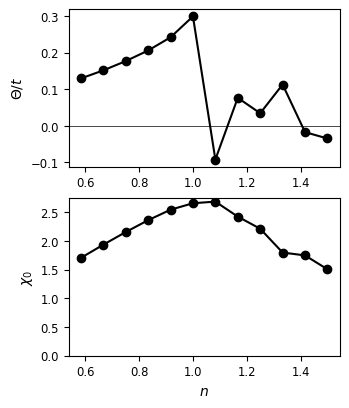

In [120]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
for kname in keys(kpoint_index)
    fig.clf()
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    let sdf = filter(x -> haskey(select_charge_lookup, x.charge), fit_df)
        ax1.plot(sdf.charge ./ n_sites, sdf[!, "intercept_$kname"], marker="o", linestyle="-", color="black")
        ax2.plot(sdf.charge ./ n_sites, sdf[!, "slope_$kname"], marker="o", linestyle="-", color="black")
    end
    ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
    ax1.set_ylabel(raw"$\Theta/t$")

    ax2.set_ylim(0, nothing)
    ax2.set_ylabel(raw"$\chi_0$")
    ax2.set_xlabel(raw"$n$")
    fig.savefig("curie-weiss-fit-$(kname)_$(shape_str).pdf", dpi=300, bbox_inches="tight")
end
# fig.savefig("weiss-temperature_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# S(q)

In [121]:
structure_factor_df = let
    Qs = Float64[]
    Ts = Float64[]
    Sqs = Vector{Float64}[]
    
    for sdf in groupby(df, [:charge, :temperature])
        T = first(sdf.temperature)
        Q = first(sdf.charge)
        Sq = zeros(Float64, length(sdf[1, :Sq]))
        Z = 0.0
        for row in eachrow(sdf)
            Sq += row.Sq
            Z += row.partition
        end
        Sq ./= Z
        push!(Qs, Q)
        push!(Ts, T)
        push!(Sqs, real.(Sq))
    end
    DataFrame("charge" => Qs, "temperature" => Ts, "structure_factor" => Sqs)
end
;

In [127]:
k0 = momentums .* 2π
G = reciprocallatticevectors
function plot_Sq(Sq::AbstractVector{<:Real}, ax::PyObject; inverse::Bool=false)
    k = Matrix{Float64}(undef, (2, 0))
    v = Vector{Float64}(undef, 0)
    if inverse
        Sq = -1 ./ Sq
    end
    for R1 in [-1,0,1], R2 in [-1,0,1]
        R = [R1; R2]
        k = hcat(k, broadcast(+, k0, G * R))
        v = vcat(v, Sq)
    end
    if inverse
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis((v .- minv) ./ (maxv - minv))
    else
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis(v ./ maxv)
    end
    img = ax.scatter(k[1,:], k[2,:], s=200, c=c, marker="h")
    ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xticks([])
    ax.set_yticks([])
    return img
end

plot_Sq (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


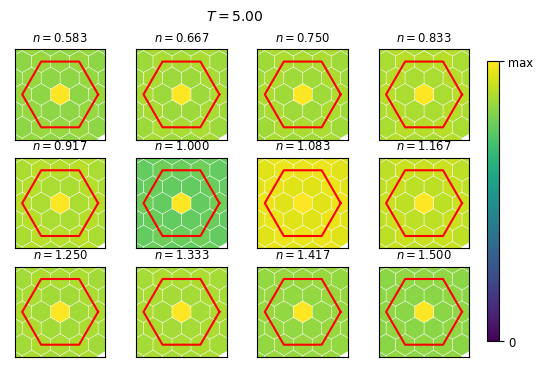

In [129]:
fig = PyPlot.figure(figsize=(6,4))

pdf = backend_pdf.PdfPages("static-structure-factor_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            Sq = copy(row.structure_factor)
            ax = axs_transpose[iq]
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
            ax.set_aspect(1.0)
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "Shape = $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


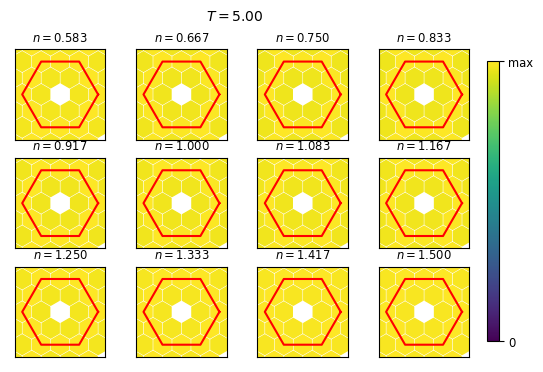

In [130]:
k0 = momentums .* 2π
G = reciprocallatticevectors

fig = PyPlot.figure(figsize=(6, 4))

pdf = backend_pdf.PdfPages("static-structure-factor-no-GM_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            ax = axs_transpose[iq]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
            ax.set_aspect(1.0)
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

## S(q) Charge per page

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


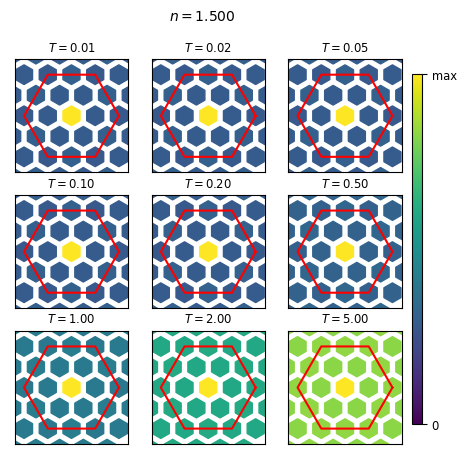

In [135]:
fig = PyPlot.figure(figsize=(5, 5))
pdf = backend_pdf.PdfPages("static-structure-factor-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
            ax.set_aspect(1.0)
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


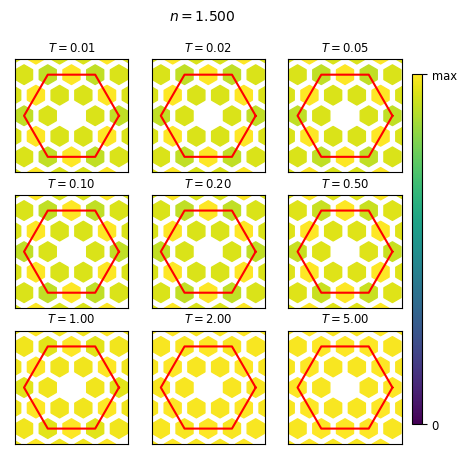

In [136]:
fig = PyPlot.figure(figsize=(5, 5))
pdf = backend_pdf.PdfPages("static-structure-factor-no-GM-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
            ax.set_aspect(1.0)            
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

# ----------- Cut Here -----------------

In [49]:
# results = []
# for T in temperatures
#     idx = df[!, :temperature] .== T
#     Z = sum(df[idx, :partition])
#     ks = [sum(df[idx, :partition] .* kmaps[i, idx]) / Z for i in 1:n_sites]
#     push!(results, (T => ks))
# end

In [50]:
# kmap_T_dependence = [hcat([[T, real(V[i])] for (T, V) in results]...) for i in 1:size(momentums,2)]

In [51]:
# for i in [1,2,5]
#     Ts = kmap_T_dependence[i][1,:]
#     Sqs = kmap_T_dependence[i][2,:]
#     χs = Sqs ./ Ts
#     PyPlot.plot(Ts, 1.0 ./ χs, "-", label="$i")
# end
# PyPlot.legend()
# PyPlot.ylim()

In [52]:
# k1 = hcat([[T, V[1]] for (T, V) in results]...)

In [53]:
# select_temperatures = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0];

In [54]:
# select_indices = [findfirst(==(y), temperatures) for y in select_temperatures]

In [55]:
# fig = PyPlot.figure(figsize=(3.5, 7))
# maxval = 0.0
# ax = nothing
# img = nothing


# for i in 1:8
#     j = select_indices[i]
#     T, Sq = results[j]
#     ax = fig.add_subplot(4,2,i)
#     k0 = momentums .* 2π
#     G = reciprocallatticevectors
#     v0 = abs2.(Sq)
#     k = Matrix{Float64}(undef, (2,0))
#     v = Vector{Float64}(undef, 0)
#     for R1 in [-1,0,1], R2 in [-1,0,1]
#         R = [R1;R2]
#         k = hcat(k, broadcast(+, k0, G * R))
#         v = vcat(v, v0)
#     end
#     img = ax.scatter(k[1,:], k[2,:], s=300, c=mpl.cm.viridis(v ./ maximum(v)), marker="H")
#     ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
#     ax.set_aspect(1.0)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title("T=$(T)")
# end
# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
# # cbar_ax.set_yticks([0, 1])
# cbar_ax.set_yticklabels(["0", "max"])

LoadError: UndefVarError: select_indices not defined

In [56]:
# reciprocallattice = hcat((reciprocallatticevectors * [R1, R2]  for R1 in [-1,0,1] for R2 in [-1,0,1])...)

2×9 Matrix{Float64}:
  -6.28319  -6.28319  -6.28319  …  0.0      6.28319  6.28319   6.28319
 -10.8828   -3.6276    3.6276      7.2552  -3.6276   3.6276   10.8828

In [57]:
# sp = pyimport("scipy")
# pyimport("scipy.spatial")

PyObject <module 'scipy.spatial' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/scipy/spatial/__init__.py'>

In [58]:
# voro = sp.spatial.Voronoi(reciprocallattice')

PyObject <scipy.spatial.qhull.Voronoi object at 0x14a22d911820>

In [59]:
# p0 = [4π/3, 0]
# R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
# zone_boundary = [p0]
# p = p0
# for i in 1:5
#     p = R * p
#     push!(zone_boundary, p)
# end
# push!(zone_boundary, p0)
# zone_boundary = hcat(zone_boundary...)

2×7 Matrix{Float64}:
 4.18879  2.0944  -2.0944  -4.18879      -2.0944   2.0944  4.18879
 0.0      3.6276   3.6276   1.51297e-15  -3.6276  -3.6276  0.0

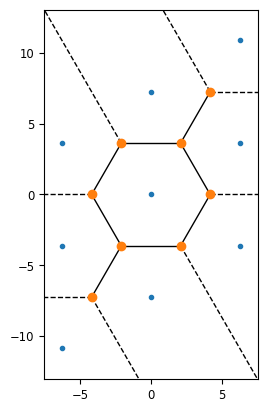

In [60]:

# sp.spatial.voronoi_plot_2d(voro)
# ax = PyPlot.gca()
# # ax.plot([0,4π/3], [0,0])
# ax.set_aspect(1.0)

In [61]:
# voro.regions
# voro.ridge_points
# voro.vertices

10-element Vector{Vector}:
 Any[]
 [1, 0, -1]
 [4, -1, 2, 3]
 [4, -1]
 [4, -1, 0, 3]
 [7, -1, 5, 6]
 [-1, 2, 5]
 [6, 1, 0, 3, 2, 5]
 [7, -1]
 [7, -1, 1, 6]

16×2 Matrix{Int32}:
 6  3
 6  4
 6  7
 1  2
 1  4
 1  0
 1  3
 0  3
 3  4
 5  2
 5  4
 5  8
 5  7
 2  4
 4  7
 8  7

8×2 Matrix{Float64}:
  2.0944   -3.6276
  4.18879   0.0
 -4.18879   0.0
 -2.0944   -3.6276
 -4.18879  -7.2552
 -2.0944    3.6276
  2.0944    3.6276
  4.18879   7.2552